In [ ]:
import numpy as np
import read_lif as lif
import texture
import h5py
from texture.grid import RegularGrid
from texture.texture import C2B, statistical_relative_deformations, tri2square
from texture.display import display2Dcount, display_matrices, display_pos_edges
from matplotlib import pyplot as plt
from importlib import reload
%matplotlib inline

In [3]:
cd ~/Documents/Akash/20200221/20200221_3/

/data/mleocmach/Documents/Akash/20200221/20200221_3


In [ ]:
with h5py.File("dirdip.h5", "r") as h5file:
    Ntot = h5file["/Ntot"]
    args = dict(Ntot.attrs)
    px = h5file["voxel_size_in_microns"][:]
    shape = Ntot.shape

In [5]:
args

{'Zfactor': 1.0,
 'commit': 'cd1a27d32aa40af5118a2694aced29e8683f3e4c',
 'datetime': '2021-06-04T22:13:28.745659',
 'endseries': 6,
 'filename': '/data/mleocmach/Documents/Akash/20200221/20200221/20200221_3_constant_stress_CAS1.lif',
 'gridstep': 8,
 'gridzstep': 4,
 'maxZ': 80,
 'minZ': 8,
 'no_clean_git': False,
 'output': 'dirdip',
 'preblur': 1.0,
 'radius': 8,
 'series': 2,
 'zradius': 4}

In [23]:
minZ = args["minZ"]
maxZ = args["maxZ"]
gridstep = args["gridstep"]
gridzstep = args["gridzstep"]
radius = args["radius"]
zradius = args["zradius"]

rea = lif.Reader(args["filename"], False)
#ser = rea.chooseSerie()
ser = rea.getSeries()[args["series"]]
frshape = ser.getFrameShape()

In [15]:
grid = RegularGrid(
    [minZ, radius, radius]*px[::-1],
    [gridzstep,  gridstep,  gridstep]*px[::-1],
    shape[1:]
    )
gridYX = RegularGrid([radius,radius], [gridstep,  gridstep], shape[2:])
gridZX = RegularGrid([zradius,radius], [gridzstep,  gridstep], [shape[1], shape[-1]])
gridYZ = RegularGrid([radius,zradius], [gridstep,  gridzstep], [shape[2], shape[1]])

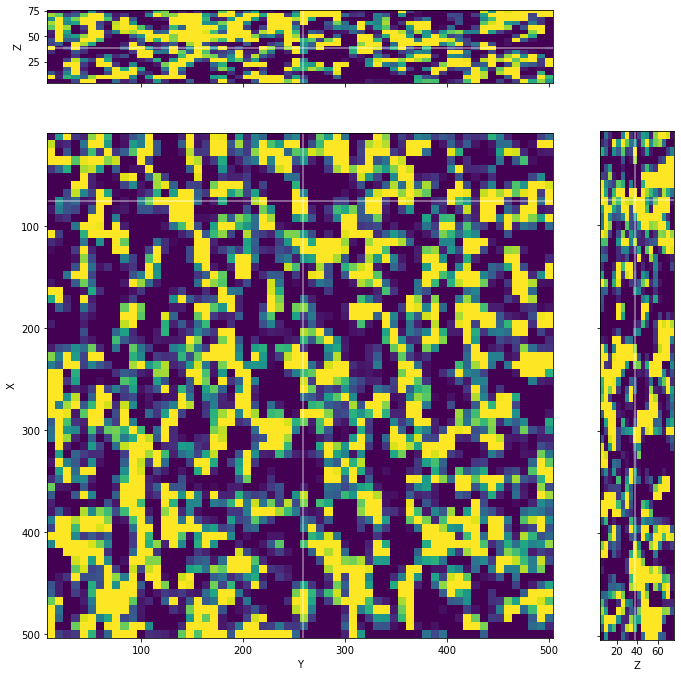

In [33]:
fig, axs = plt.subplots(
    2,2, figsize=(10,10), sharex='col', sharey='row', 
    subplot_kw={'aspect': 'equal'}, 
    gridspec_kw={
        'width_ratios':[shape[2],shape[1]], 
        'height_ratios':[shape[1],shape[2]]
    }
)
t = 38
Z = 30
Y = 251
X = 67
vmax=100
lc = (1,1,1,0.5)

with h5py.File("dirdip_PIV.h5", "r") as h5file:
    count = h5file["/Ntot"][t]

axs[1,0].axhline(X+radius, color=lc)
axs[1,0].axvline(Y+radius, color=lc)
display2Dcount(axs[1,0], gridYX, count[(Z-minZ)//gridzstep], vmin=0, vmax=vmax)
axs[1,0].set_xlabel('Y')
axs[1,0].set_ylabel('X')


axs[0,0].axhline(Z+minZ, color=lc)
axs[0,0].axvline(Y+radius, color=lc)
display2Dcount(axs[0,0], gridYZ, count[:,:,(X-radius)//gridstep].T, vmin=0, vmax=vmax)
axs[0,0].set_ylabel('Z')


axs[1,1].axhline(X+radius, color=lc)
axs[1,1].axvline(Z+minZ, color=lc)
display2Dcount(axs[1,1], gridZX, count[:,(Y-radius)//gridstep], vmin=0, vmax=vmax)
axs[1,1].set_xlabel('Z')

axs[1,0].invert_yaxis()
axs[0,1].set_visible(False)
plt.tight_layout()

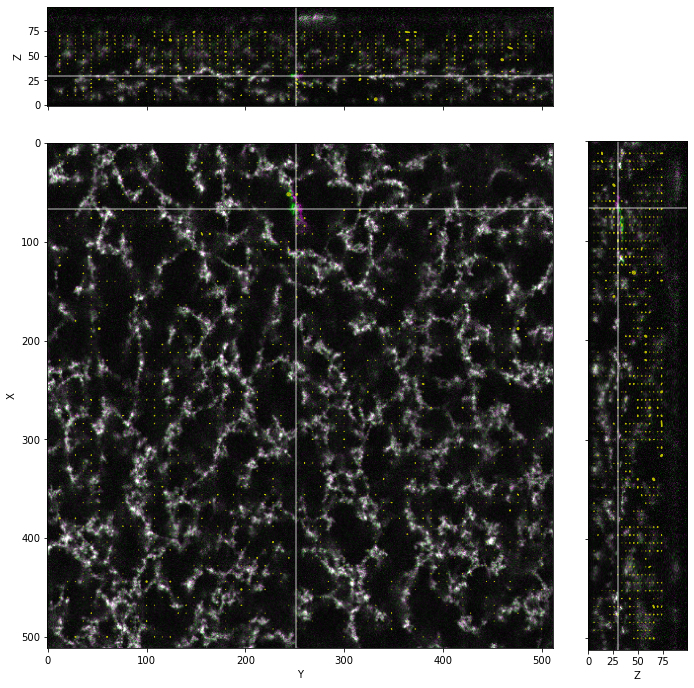

In [34]:
#geometric texture evolution (relative)
fig, axs = plt.subplots(
    2,2, figsize=(10,10), sharex='col', sharey='row', 
    subplot_kw={'aspect': 'equal'}, 
    gridspec_kw={
        'width_ratios':[shape[2],shape[1]], 
        'height_ratios':[shape[1],shape[2]]
    }
)
t = 38
Z = 30
Y = 251
X = 67
scale=20
vmax=100

with h5py.File("dirdip_PIV.h5", "r") as h5file:
    Ntot = h5file["/Ntot"][t]
    Ntot_nz = 1/np.maximum(1, Ntot)
    M = h5file["/sumM"][t] * Ntot_nz[...,None]
    C = h5file["/sumC"][t] * Ntot_nz[...,None,None]
    T = h5file["/sumT"][t] * Ntot_nz[...,None]

# link to continuous mechanics
V, Omega, P = statistical_relative_deformations(M, C, T)

axs[1,0].imshow(np.dstack([ser.getFrame(t+dt)[Z].T for dt in range(2)])[...,[0,1,0]], 'gray')
axs[1,0].axhline(X, color=lc)
axs[1,0].axvline(Y, color=lc)
display_matrices(axs[1,0], gridYX, V[(Z-minZ)//gridzstep, ...,3:], scale=scale, col='y')


axs[0,0].imshow(np.dstack([ser.getFrame(t+dt)[:,:,X] for dt in range(2)])[...,[0,1,0]], 'gray')
axs[0,0].axhline(Z, color=lc)
axs[0,0].axvline(Y, color=lc)
display_matrices(axs[0,0], gridYZ, V[:,:,(X-radius)//gridstep, ...,[0,1,3]].T, scale=scale, col='y')
axs[0,0].invert_yaxis()

axs[1,1].imshow(np.dstack([ser.getFrame(t+dt)[:,Y].T for dt in range(2)])[...,[0,1,0]], 'gray')
axs[1,1].axhline(X, color=lc)
axs[1,1].axvline(Z, color=lc)
display_matrices(axs[1,1], gridZX, V[:,(Y-radius)//gridstep][...,[5,2,0]], scale=scale, col='y')

axs[0,1].set_visible(False)
axs[1,0].set_xlabel('Y')
axs[1,0].set_ylabel('X')
axs[0,0].set_ylabel('Z')
axs[1,1].set_xlabel('Z')
plt.tight_layout()

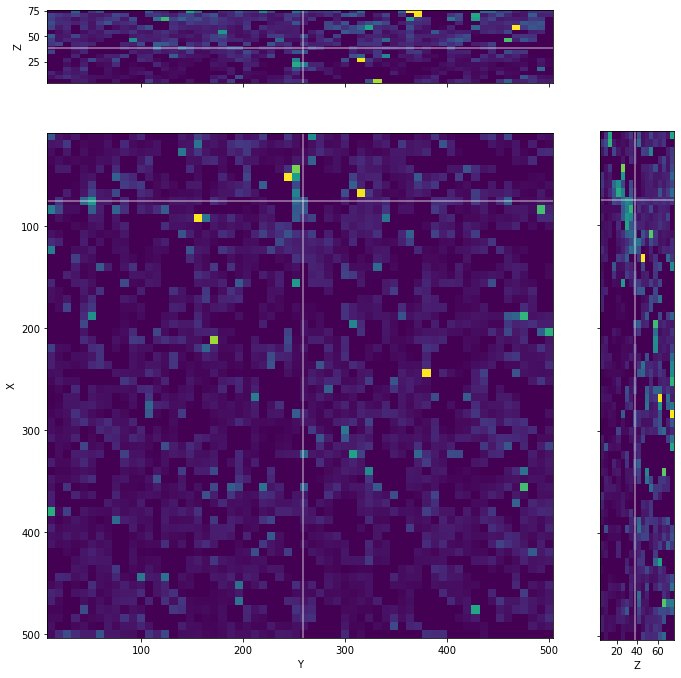

In [39]:
fig, axs = plt.subplots(
    2,2, figsize=(10,10), sharex='col', sharey='row', 
    subplot_kw={'aspect': 'equal'}, 
    gridspec_kw={
        'width_ratios':[shape[2],shape[1]], 
        'height_ratios':[shape[1],shape[2]]
    }
)
t = 38
Z = 30
Y = 251
X = 67
vmax=100
lc = (1,1,1,0.5)

with h5py.File("dirdip_PIV.h5", "r") as h5file:
    Ntot = h5file["/Ntot"][t]
    Ntot_nz = 1/np.maximum(1, Ntot)
    M = h5file["/sumM"][t] * Ntot_nz[...,None]
    C = h5file["/sumC"][t] * Ntot_nz[...,None,None]
    T = h5file["/sumT"][t] * Ntot_nz[...,None]

# link to continuous mechanics
V, Omega, P = statistical_relative_deformations(M, C, T)
normV = np.linalg.norm(tri2square(V), axis=(-2,-1))
vmax= 0.25#normV.max()

axs[1,0].axhline(X+radius, color=lc)
axs[1,0].axvline(Y+radius, color=lc)
display2Dcount(axs[1,0], gridYX, normV[(Z-minZ)//gridzstep], vmin=0, vmax=vmax)
axs[1,0].set_xlabel('Y')
axs[1,0].set_ylabel('X')


axs[0,0].axhline(Z+minZ, color=lc)
axs[0,0].axvline(Y+radius, color=lc)
display2Dcount(axs[0,0], gridYZ, normV[:,:,(X-radius)//gridstep].T, vmin=0, vmax=vmax)
axs[0,0].set_ylabel('Z')


axs[1,1].axhline(X+radius, color=lc)
axs[1,1].axvline(Z+minZ, color=lc)
display2Dcount(axs[1,1], gridZX, normV[:,(Y-radius)//gridstep], vmin=0, vmax=vmax)
axs[1,1].set_xlabel('Z')

axs[1,0].invert_yaxis()
axs[0,1].set_visible(False)
plt.tight_layout()

In [36]:
normV.max()

2.980373629236604

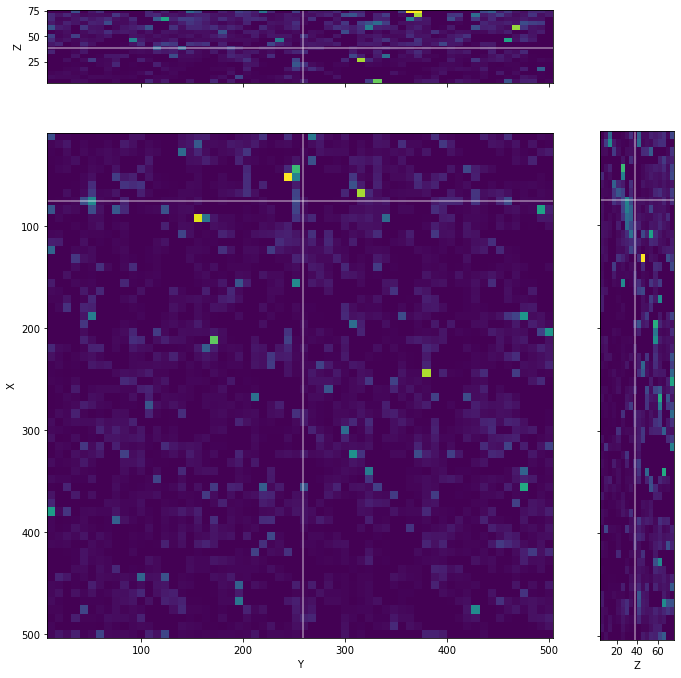

In [45]:
fig, axs = plt.subplots(
    2,2, figsize=(10,10), sharex='col', sharey='row', 
    subplot_kw={'aspect': 'equal'}, 
    gridspec_kw={
        'width_ratios':[shape[2],shape[1]], 
        'height_ratios':[shape[1],shape[2]]
    }
)
t = 38
Z = 30
Y = 251
X = 67
vmax=100
lc = (1,1,1,0.5)

with h5py.File("dirdip_PIV.h5", "r") as h5file:
    Ntot = h5file["/Ntot"][t]
    Ntot_nz = 1/np.maximum(1, Ntot)
    M = h5file["/sumM"][t] * Ntot_nz[...,None]
    C = h5file["/sumC"][t] * Ntot_nz[...,None,None]
    T = h5file["/sumT"][t] * Ntot_nz[...,None]

# link to continuous mechanics
V, Omega, P = statistical_relative_deformations(M, C, T)
normO = np.linalg.norm(Omega, axis=(-1))
vmax= 0.2#normO.max()

axs[1,0].axhline(X+radius, color=lc)
axs[1,0].axvline(Y+radius, color=lc)
display2Dcount(axs[1,0], gridYX, normO[(Z-minZ)//gridzstep], vmin=0, vmax=vmax)
axs[1,0].set_xlabel('Y')
axs[1,0].set_ylabel('X')


axs[0,0].axhline(Z+minZ, color=lc)
axs[0,0].axvline(Y+radius, color=lc)
display2Dcount(axs[0,0], gridYZ, normO[:,:,(X-radius)//gridstep].T, vmin=0, vmax=vmax)
axs[0,0].set_ylabel('Z')


axs[1,1].axhline(X+radius, color=lc)
axs[1,1].axvline(Z+minZ, color=lc)
display2Dcount(axs[1,1], gridZX, normO[:,(Y-radius)//gridstep], vmin=0, vmax=vmax)
axs[1,1].set_xlabel('Z')

axs[1,0].invert_yaxis()
axs[0,1].set_visible(False)
plt.tight_layout()

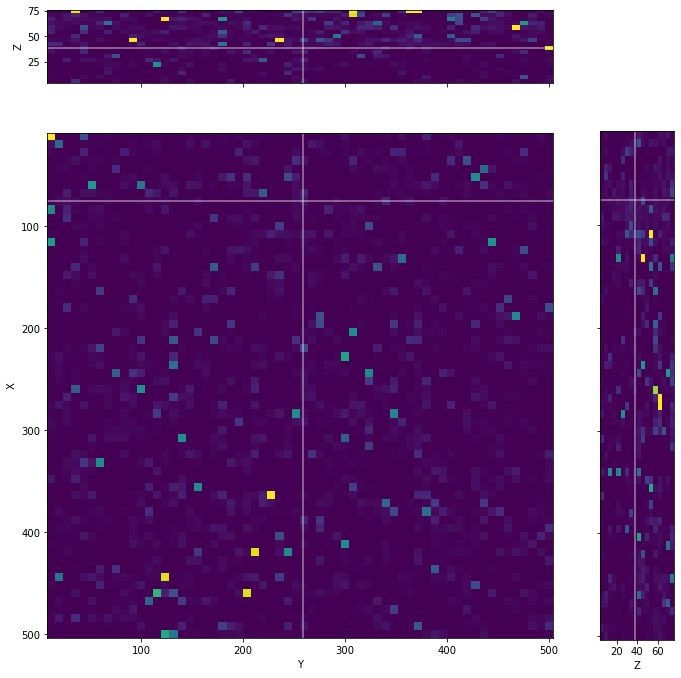

In [46]:
fig, axs = plt.subplots(
    2,2, figsize=(10,10), sharex='col', sharey='row', 
    subplot_kw={'aspect': 'equal'}, 
    gridspec_kw={
        'width_ratios':[shape[2],shape[1]], 
        'height_ratios':[shape[1],shape[2]]
    }
)
t = 38
Z = 30
Y = 251
X = 67
vmax=100
lc = (1,1,1,0.5)

with h5py.File("dirdip_PIV.h5", "r") as h5file:
    Ntot = h5file["/Ntot"][t]
    Ntot_nz = 1/np.maximum(1, Ntot)
    M = h5file["/sumM"][t] * Ntot_nz[...,None]
    C = h5file["/sumC"][t] * Ntot_nz[...,None,None]
    T = h5file["/sumT"][t] * Ntot_nz[...,None]

# link to continuous mechanics
V, Omega, P = statistical_relative_deformations(M, C, T)
normP = np.linalg.norm(tri2square(P), axis=(-2,-1))
vmax= 0.25#normV.max()

axs[1,0].axhline(X+radius, color=lc)
axs[1,0].axvline(Y+radius, color=lc)
display2Dcount(axs[1,0], gridYX, normP[(Z-minZ)//gridzstep], vmin=0, vmax=vmax)
axs[1,0].set_xlabel('Y')
axs[1,0].set_ylabel('X')


axs[0,0].axhline(Z+minZ, color=lc)
axs[0,0].axvline(Y+radius, color=lc)
display2Dcount(axs[0,0], gridYZ, normP[:,:,(X-radius)//gridstep].T, vmin=0, vmax=vmax)
axs[0,0].set_ylabel('Z')


axs[1,1].axhline(X+radius, color=lc)
axs[1,1].axvline(Z+minZ, color=lc)
display2Dcount(axs[1,1], gridZX, normP[:,(Y-radius)//gridstep], vmin=0, vmax=vmax)
axs[1,1].set_xlabel('Z')

axs[1,0].invert_yaxis()
axs[0,1].set_visible(False)
plt.tight_layout()

In [47]:
normP.max()

3.7653035419890943

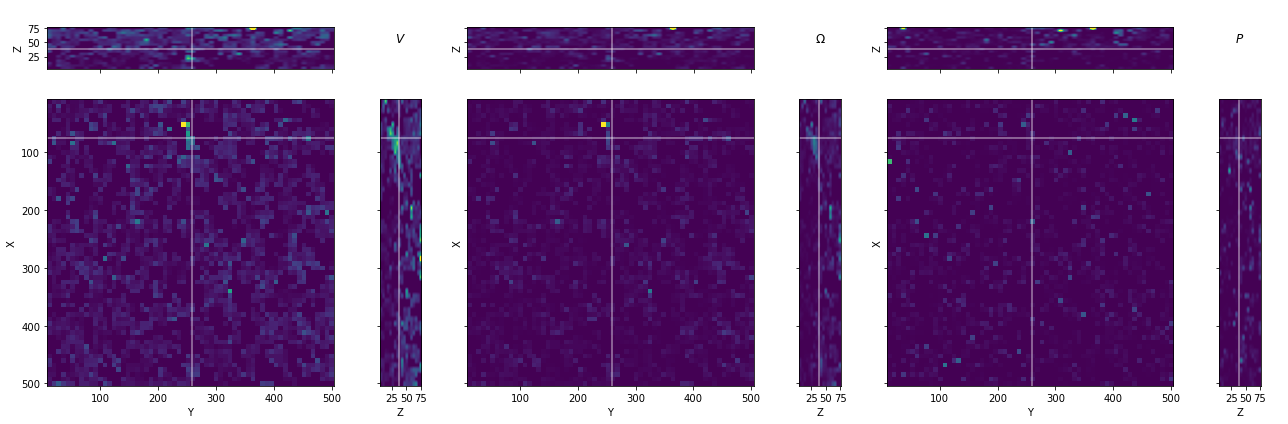

In [69]:
fig, axs_all = plt.subplots(
    2,6, figsize=(18,6), sharex='col', sharey='row', 
    subplot_kw={'aspect': 'equal'}, 
    gridspec_kw={
        'width_ratios':[shape[2],shape[1]]*3, 
        'height_ratios':[shape[1],shape[2]]
    }
)
t = 38
Z = 30
Y = 251
X = 67
Nmin=10
lc = (1,1,1,0.5)

with h5py.File("dirdip_PIV.h5", "r") as h5file:
    Ntot = h5file["/Ntot"][t]
    Ntot_nz = 1/np.maximum(1, Ntot)
    M = h5file["/sumM"][t] * Ntot_nz[...,None]
    C = h5file["/sumC"][t] * Ntot_nz[...,None,None]
    T = h5file["/sumT"][t] * Ntot_nz[...,None]

# link to continuous mechanics
V, Omega, P = statistical_relative_deformations(M, C, T)
normV = np.linalg.norm(tri2square(V), axis=(-2,-1)) * (Ntot>Nmin)
normO = np.linalg.norm(Omega, axis=(-1)) * (Ntot>Nmin)
normP = np.linalg.norm(tri2square(P), axis=(-2,-1)) * (Ntot>Nmin)

for i, normF, vmax, title in zip(range(3), [normV, normO, normP], [0.2]*3, ['$V$', r'$\Omega$', '$P$']):
    axs = axs_all[:,2*i:2*(i+1)]

    axs[1,0].axhline(X+radius, color=lc)
    axs[1,0].axvline(Y+radius, color=lc)
    display2Dcount(axs[1,0], gridYX, normF[(Z-minZ)//gridzstep], vmin=0, vmax=vmax)
    axs[1,0].set_xlabel('Y')
    axs[1,0].set_ylabel('X')


    axs[0,0].axhline(Z+minZ, color=lc)
    axs[0,0].axvline(Y+radius, color=lc)
    display2Dcount(axs[0,0], gridYZ, normF[:,:,(X-radius)//gridstep].T, vmin=0, vmax=vmax)
    axs[0,0].set_ylabel('Z')


    axs[1,1].axhline(X+radius, color=lc)
    axs[1,1].axvline(Z+minZ, color=lc)
    display2Dcount(axs[1,1], gridZX, normF[:,(Y-radius)//gridstep], vmin=0, vmax=vmax)
    axs[1,1].set_xlabel('Z')
    
    axs[0,1].set_axis_off()#set_visible(False)
    axs[0,1].set_title(title, y=0.5)

axs_all[1,0].invert_yaxis()

plt.tight_layout()

In [55]:
normV.max()

0.7902713003209737

## Local maxima in Vtot

In [58]:
from scipy.ndimage import grey_dilation

t = 38

with h5py.File("dirdip_PIV.h5", "r") as h5file:
    Ntot = h5file["/Ntot"][t]
    Ntot_nz = 1/np.maximum(1, Ntot)
    M = h5file["/sumM"][t] * Ntot_nz[...,None]
    C = h5file["/sumC"][t] * Ntot_nz[...,None,None]
    T = h5file["/sumT"][t] * Ntot_nz[...,None]

# link to continuous mechanics
V, Omega, P = statistical_relative_deformations(M, C, T)
normV = np.linalg.norm(tri2square(V), axis=(-2,-1))

localmax = grey_dilation(normV,3) == normV
vlocalmax = normV[localmax]

In [59]:
localmax.sum()

2643

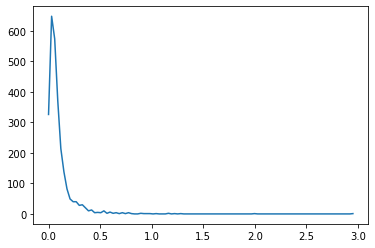

In [61]:
h,b = np.histogram(vlocalmax, bins=100)
plt.plot(b[:-1], h)

In [65]:
np.percentile(normV, 90)

0.04854513743069438